## **Predicting Disease Spread: Model Arima**

### **Imports**

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.arima import (
    forecast_dengue_cases_arima,
    plot_forecast,
)

import warnings
warnings.filterwarnings("ignore")

### **Data**

In [2]:
features_train, labels_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_labels_train, iq_labels_train = split_cities(labels_train)

In [3]:
features_test, labels_test = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

#### Drop only non-numeric, irrelevant column

In [4]:
sj_features_train_num = sj_features_train.drop(columns=["week_start_date"])
sj_features_test_num = sj_features_test.drop(columns=["week_start_date"])
iq_features_train_num = iq_features_train.drop(columns=["week_start_date"])
iq_features_test_num = iq_features_test.drop(columns=["week_start_date"])

### **Predictions**

In [5]:
X_train_dict = {'sj': sj_features_train, 'iq': iq_features_train}
y_train_dict = {'sj': sj_labels_train, 'iq': iq_labels_train}
X_test_dict = {'sj': sj_features_test, 'iq': iq_features_test}

In [6]:
y_sj = y_train_dict['sj'].copy()
X_sj = X_train_dict['sj'].copy()

# add date
y_sj['ds'] = pd.to_datetime(X_sj['week_start_date'].values)

y_sj_series = pd.Series(y_sj['total_cases'].values, index=y_sj['ds'])

# deseasonalize the data, I component equal 1 (d=1) 
y_sj_deseasonalized = y_sj_series.diff(1).dropna()

ADF Statistic: 5.147318673759364e-09


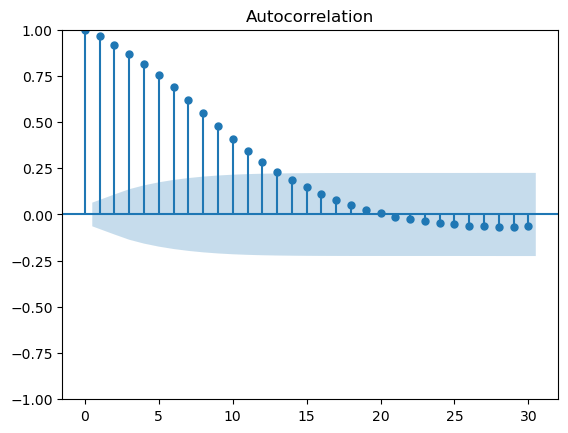

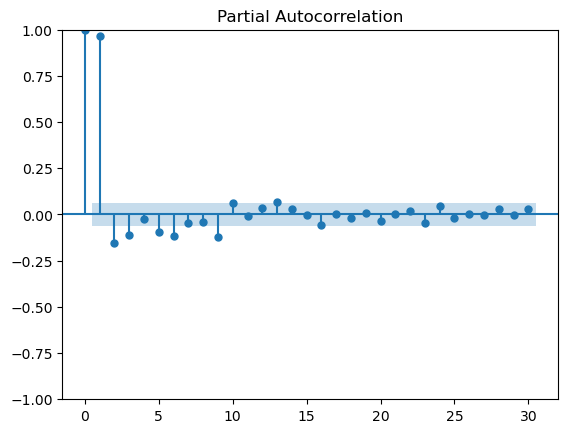

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(y_sj_series)

pacf = plot_pacf(y_sj_series)
adfuller_result = adfuller(y_sj_series)
print(f'ADF Statistic: {adfuller_result[1]}')

From the ACF and PACF plots AR component should be 1 (p=1), so the MA component is 0 (q=1). -> ARIMA(1, 1, 0) for San Juan

In [8]:
y_iq = y_train_dict['iq'].copy()
X_iq = X_train_dict['iq'].copy()

# add date
y_iq['ds'] = pd.to_datetime(X_iq['week_start_date'].values)

y_iq_series = pd.Series(y_iq['total_cases'].values, index=y_iq['ds'])

# deseasonalize the data, I component equal 1 (d=1) 
y_iq_deseasonalized = y_iq_series.diff(1).dropna()

ADF Statistic: 1.0672522948401997e-07


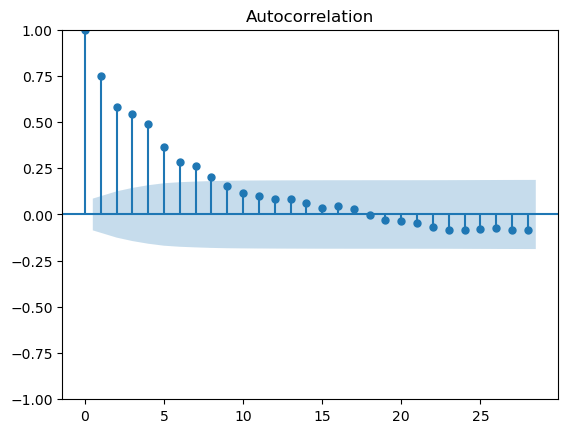

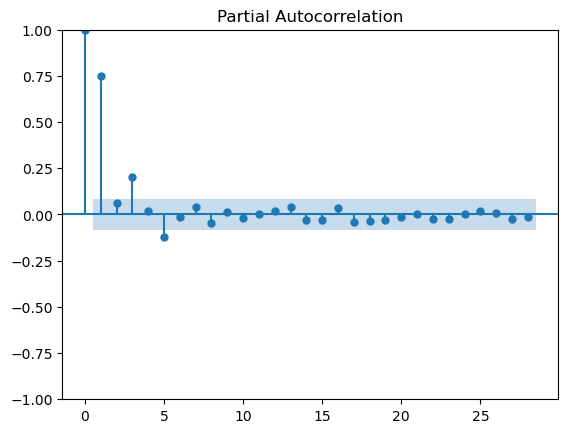

In [9]:
acf = plot_acf(y_iq_series)

pacf = plot_pacf(y_iq_series)
adfuller_result = adfuller(y_iq_series)
print(f'ADF Statistic: {adfuller_result[1]}')

From the ACF and PACF plots AR component should be 1 (p=1), so the MA component is 0 (q=1). -> ARIMA(2, 1, 0) for Iquitos

Processing ARIMA for sj...
ARIMA summary for sj:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  936
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3739.491
Date:                Thu, 03 Apr 2025   AIC                           7488.982
Time:                        09:03:03   BIC                           7513.191
Sample:                             0   HQIC                          7498.213
                                - 936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4932      0.158      3.129      0.002       0.184       0.802
ar.L1          1.8504      0.027     68.911      0.000       1.798       1.903
ar.

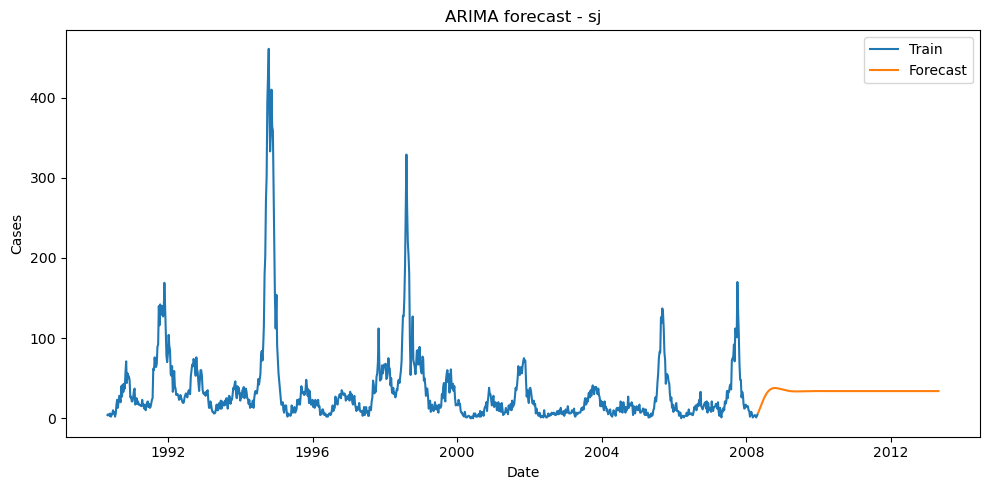

Processing ARIMA for iq...
ARIMA summary for iq:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  520
Model:             SARIMAX(3, 0, 2)x(2, 0, [], 52)   Log Likelihood               -1737.979
Date:                             Thu, 03 Apr 2025   AIC                           3493.957
Time:                                     09:27:33   BIC                           3532.242
Sample:                                          0   HQIC                          3508.955
                                             - 520                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5116      0.834      1.812      0.070   

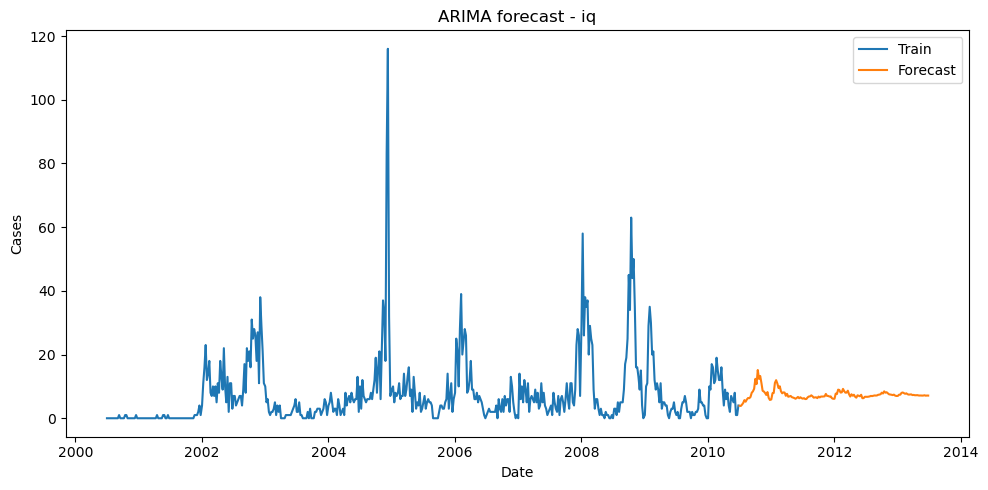

    city  year  weekofyear  total_cases
0     sj  2008          18            7
1     sj  2008          19            9
2     sj  2008          20           12
3     sj  2008          21           14
4     sj  2008          22           16
..   ...   ...         ...          ...
151   iq  2013          22            7
152   iq  2013          23            7
153   iq  2013          24            7
154   iq  2013          25            7
155   iq  2013          26            7

[416 rows x 4 columns]


In [10]:
predictions = forecast_dengue_cases_arima(X_train_dict, y_train_dict, X_test_dict)

all_arima_results = []
for city, preds in predictions.items():
    city_test = X_test_dict[city]
    city_results = pd.DataFrame({
        'city': city,
        'year': city_test.index.get_level_values('year'),
        'weekofyear': city_test.index.get_level_values('weekofyear'),
        'total_cases': np.round(preds).clip(0).astype(int)
    })
    all_arima_results.append(city_results)

final_arima_predictions = pd.concat(all_arima_results)
print(final_arima_predictions)

In [11]:
# final_arima_predictions.to_csv('../data/predictions/prophet.csv', index=False)